# COVID-19 & Stay-at-Home Orders in the US

#### Cameron Cofskey

## Introduction 

### Sources

This analysis focuses on the effectiveness of stay-at-home orders in the United States by state. The data comes from 2 sources: 

* *New York Times* - "See Which States and Cities Have Told Residents to Stay at Home" (https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html)
    * Provides stay-at-home order dates and population for each state
* *Kaggle* - "COVID-19 in USA" (https://www.kaggle.com/sudalairajkumar/covid19-in-usa/version/32#us_states_covid19_daily.csv)
    * Provides data on the number of cases, positive tests and deaths for each day & state

### Abstract

There are a couple of ideas that will be important to the understanding of this analysis. 

1. **Limited Disease Spread** - This is the idea / belief that there will be a fixed number of COVID-19 cases in the United States. It can be helpful to think of this in terms of a fixed time period (e.g. the next year, 5 years, or the eventual eradication of the disease). No matter the time period, there will be a fixed number of cases of COVID-19 contracted, though we do not yet know what this number will be. 

2. **Limited Healthcare Capacity** - This is the idea that at any given point of time, there is a maximum capacity of our healthcare system. Above this point, the quality of care will diminish or disappear altogether, leading to a greater number of higher severity cases and even death.

3. **Flattening the Curve** - This idea has become a bit of a buzzword recently, but what does it really mean? In its simplest form, it is merely a combination of the first 2 statements above. There are (and will continue to be) cases of COVID-19 in the United States. The key to overcoming this disease and returning to some normalcy will require that the cases do not occur in too close of proximity to each other, due to the limited healthcare capacity. If we are able to spread out the cases over a longer time frame, it gives healthcare workers, scientists working on a vaccine, the government, and others more time to react to these unprecedented events. 

**Summary**: 

* **Goal** - Minimize the cumulative number of deaths
* **How** - Spreading out the number of positive cases over as long of a time frame as possible
* **Metrics of Success** - The rate of change of the number of positive cases & the rate of change of the death rate. 

This analysis focuses on the metrics of success for each state.

## Import Packages

In [1]:
import requests # html reader
from bs4 import BeautifulSoup # html parsing
import pandas as pd # data frames
import datetime # date calculations
import matplotlib.pyplot as plt # plotting
import fbprophet # forecasting
import math # basic math functions
import matplotlib.dates as mdates # date formatting
from sklearn.neural_network import MLPRegressor # model building
from sklearn.model_selection import train_test_split # model test / train splitting

Importing plotly failed. Interactive plots will not work.


## Scrape NYT article

### Initialize Beautiful Soup Object

In [2]:
# Get URL
URL = 'https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html'
page = requests.get(URL)

In [3]:
# Initialize Soup Object
soup = BeautifulSoup(page.content, 'html.parser')

### Parse HTML & Format Results

In [4]:
# Dig into list-wrap element of html, where state data exists
results = soup.find('div', class_= 'list-wrap')

In [5]:
# Each state is divided by this header
state_orders = results.find_all('div', class_='state-wrap statewide')

In [6]:
# Pull the specific elements where each data element is & extract the info

# Initialize lists to store data
State = []
population_elem = []
order_date_elem = []

for state_orders in state_orders:
    State.append(state_orders['data-state'])
    population_elem.append(state_orders.find('span', class_='l-population').text)
    order_date_elem.append(state_orders.find('span', class_='l-date').text)

In [7]:
# Format the population data into a list
Population = []

for population_elem in population_elem:
    text = population_elem.split()
    if text[2] == 'million':
        Population.append(int(float(text[1]) * 1000000))
    else:
        Population.append(int(text[1].replace(',', '')))

In [8]:
# Format the date information into a list
SAH_Month = []
SAH_Day = []

for order_date_elem in order_date_elem:
    text = order_date_elem.split()
    SAH_Month.append(text[2])
    SAH_Day.append(text[3])

# Reformat Month to number
for i in range(len(SAH_Month)):
    datetime_object = datetime.datetime.strptime(SAH_Month[i], "%B")
    month_number = datetime_object.month
    SAH_Month[i] = month_number

In [9]:
# Create the Year list to match the others
SAH_Year = []
for i in range(len(SAH_Month)):
    SAH_Year.append(2020)

In [10]:
# Create date column
date = pd.DataFrame({'year' : SAH_Year,
                     'month' : SAH_Month,
                     'day' : SAH_Day})
Date = pd.to_datetime(date[['month', 'day', 'year']])

### Store results in dataframe 

In [11]:
# Create data frame
dict = {'state' : State, 
        'SAH_Order_Date' : Date,
        'Population' : Population
       }
SAH_data = pd.DataFrame(dict)

# Sort by state name & then SAH Order date
SAH_data = SAH_data.sort_values(by = ['state', 'SAH_Order_Date'], ascending= (True, True)) 
SAH_data.head()

,state,SAH_Order_Date,Population
1,AK,2020-03-28,737000
0,AL,2020-04-04,4900000
2,AZ,2020-03-31,7200000
3,CA,2020-03-19,39600000
4,CO,2020-03-26,5700000


## Initialize Kaggle Data

### Import Data

In [12]:
# Import data & look at features
states = pd.read_csv('C:/Users/camco/Downloads/us_states_covid19_daily.csv')
states.shape

(2228, 25)

In [13]:
states.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200414,AK,285.0,8063.0,NaN,NaN,32.0,NaN,NaN,NaN,...,32.0,8348.0,8348.0,8348.0,2,1.0,0.0,510.0,8.0,518.0
1,20200414,AL,3876.0,29241.0,NaN,NaN,493.0,NaN,210.0,NaN,...,493.0,33117.0,33117.0,33117.0,1,11.0,36.0,3793.0,142.0,3935.0
2,20200414,AR,1480.0,19651.0,NaN,81.0,130.0,NaN,43.0,29.0,...,130.0,21131.0,21131.0,21131.0,5,0.0,0.0,257.0,70.0,327.0
3,20200414,AS,0.0,3.0,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,20.0,3.0,3.0,60,0.0,0.0,0.0,0.0,0.0
4,20200414,AZ,3806.0,40290.0,NaN,580.0,NaN,286.0,NaN,216.0,...,NaN,44096.0,44096.0,44096.0,4,9.0,0.0,645.0,104.0,749.0


### Format

In [14]:
# Replace NA's with 0's
states.isna().sum()
states = states.fillna(value = 0)
states.isna().sum()

date                        0
state                       0
positive                    0
negative                    0
pending                     0
hospitalizedCurrently       0
hospitalizedCumulative      0
inIcuCurrently              0
inIcuCumulative             0
onVentilatorCurrently       0
onVentilatorCumulative      0
recovered                   0
hash                        0
dateChecked                 0
death                       0
hospitalized                0
total                       0
totalTestResults            0
posNeg                      0
fips                        0
deathIncrease               0
hospitalizedIncrease        0
negativeIncrease            0
positiveIncrease            0
totalTestResultsIncrease    0
dtype: int64

In [15]:
# Change date string to date
states['date'] = pd.to_datetime(states['date'], format = '%Y%m%d')

In [16]:
# Sort values
states = states.sort_values(by = ['state', 'date'], ascending= (True, False))

### Reduce dataset to columns needed for analysis

In [17]:
# Reduce to columns used in analysis
states_analysis = states[['date', 'state', 'positive', 'death', 'hospitalized', 'deathIncrease', 'hospitalizedIncrease', 'positiveIncrease']]
states_analysis.head()

,date,state,positive,death,hospitalized,deathIncrease,hospitalizedIncrease,positiveIncrease
0,2020-04-14,AK,285.0,9.0,32.0,1.0,0.0,8.0
56,2020-04-13,AK,277.0,8.0,32.0,0.0,1.0,5.0
112,2020-04-12,AK,272.0,8.0,31.0,0.0,0.0,15.0
168,2020-04-11,AK,257.0,8.0,31.0,1.0,3.0,11.0
224,2020-04-10,AK,246.0,7.0,28.0,0.0,1.0,11.0


## Join Datasets

In [18]:
# Join datasets
data = pd.merge(states_analysis, SAH_data, on='state')
data.shape

(1792, 10)

This join reduces the number of observations from 2228 to 1792, because not all states in the COVID dataset are in the New York Times article. I decided that this was acceptable since I need the stay-at-home order dates for each state in order to do my analysis.

In [19]:
data.head()

,date,state,positive,death,hospitalized,deathIncrease,hospitalizedIncrease,positiveIncrease,SAH_Order_Date,Population
0,2020-04-14,AK,285.0,9.0,32.0,1.0,0.0,8.0,2020-03-28,737000
1,2020-04-13,AK,277.0,8.0,32.0,0.0,1.0,5.0,2020-03-28,737000
2,2020-04-12,AK,272.0,8.0,31.0,0.0,0.0,15.0,2020-03-28,737000
3,2020-04-11,AK,257.0,8.0,31.0,1.0,3.0,11.0,2020-03-28,737000
4,2020-04-10,AK,246.0,7.0,28.0,0.0,1.0,11.0,2020-03-28,737000


## Calculations

### Reponse Time (SAH Order Date minus Date of 1st case in the state)

In [49]:
# Define function
row1 = data.loc[0]
def response(df):
    for i in range(len(df)):
        name = df['state'].loc[i]
        first_case_date = min(data['date'].loc[(data['state'] == name) & (data['positive'] > 0)])
        y = (SAH_data['SAH_Order_Date'].loc[i] - first_case).dt.days
        return y





In [50]:
SAH_data['Response_time'] = SAH_data.apply(response, axis = 1)

AttributeError: ("'str' object has no attribute 'loc'", 'occurred at index 1')

### ROC of Death Increase

In [20]:
# Calculate rate of change in death increases
data['deathIncrease_ROC'] = data['deathIncrease'].diff(periods = -1)

In [21]:
# Fix last row in each state group
last_row_index = data.groupby('state').tail(1).index
for i in range(len(last_row_index)):
    data.at[last_row_index[i], 'deathIncrease_ROC'] = 0
data

,date,state,positive,death,hospitalized,deathIncrease,hospitalizedIncrease,positiveIncrease,SAH_Order_Date,Population,deathIncrease_ROC
0,2020-04-14,AK,285.0,9.0,32.0,1.0,0.0,8.0,2020-03-28,737000,1.0
1,2020-04-13,AK,277.0,8.0,32.0,0.0,1.0,5.0,2020-03-28,737000,0.0
2,2020-04-12,AK,272.0,8.0,31.0,0.0,0.0,15.0,2020-03-28,737000,-1.0
3,2020-04-11,AK,257.0,8.0,31.0,1.0,3.0,11.0,2020-03-28,737000,1.0
4,2020-04-10,AK,246.0,7.0,28.0,0.0,1.0,11.0,2020-03-28,737000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1787,2020-03-10,WV,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-24,1800000,0.0
1788,2020-03-09,WV,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-24,1800000,0.0
1789,2020-03-08,WV,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-24,1800000,0.0
1790,2020-03-07,WV,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-24,1800000,0.0


### Death Rate per Million

In [22]:
# Create death rate & deaths per million columns
data['deaths_per_M'] = data['death'] / (data['Population'] / 1000000) # Deaths
data['death_rt_per_M'] = data['deathIncrease'] / (data['Population'] / 1000000) # Death rate
data['deathIncrease_ROC_per_M'] = data['deathIncrease_ROC'] / (data['Population'] / 1000000) # ROC Death rate

In [23]:
max_death_rate_per_M = data.groupby('state').agg({'death_rt_per_M' : ['max']})

In [24]:
max_death_per_M = data.groupby('state').agg({'deaths_per_M' : ['max'],
                                             'death_rt_per_M' : ['max'],
                                             'deathIncrease_ROC_per_M' : ['max']})
max_death_per_M.head()


,deaths_per_M,death_rt_per_M,deathIncrease_ROC_per_M
,max,max,max
state,,,
AK,12.211669,2.713704,2.713704
AL,22.448980,2.653061,1.224490
AZ,18.194444,1.666667,0.972222
CA,19.141414,2.777778,2.777778
CO,54.035088,10.000000,7.543860


### Divide data into before and after each stay at home order

In [25]:
# Define function
row1 = data.loc[0]
def after_SAH(row):
    if row['date'] > row['SAH_Order_Date']:
        y = 1
    else:
        y = 0
    return y
after_SAH(row1)

1

In [26]:
data['after_SAH_Order'] = data.apply(after_SAH, axis = 1)
data.head()

,date,state,positive,death,hospitalized,deathIncrease,hospitalizedIncrease,positiveIncrease,SAH_Order_Date,Population,deathIncrease_ROC,deaths_per_M,death_rt_per_M,deathIncrease_ROC_per_M,after_SAH_Order
0,2020-04-14,AK,285.0,9.0,32.0,1.0,0.0,8.0,2020-03-28,737000,1.0,12.211669,1.356852,1.356852,1
1,2020-04-13,AK,277.0,8.0,32.0,0.0,1.0,5.0,2020-03-28,737000,0.0,10.854817,0.000000,0.000000,1
2,2020-04-12,AK,272.0,8.0,31.0,0.0,0.0,15.0,2020-03-28,737000,-1.0,10.854817,0.000000,-1.356852,1
3,2020-04-11,AK,257.0,8.0,31.0,1.0,3.0,11.0,2020-03-28,737000,1.0,10.854817,1.356852,1.356852,1
4,2020-04-10,AK,246.0,7.0,28.0,0.0,1.0,11.0,2020-03-28,737000,0.0,9.497965,0.000000,0.000000,1


In [27]:
# Divide data into before and after the stay at home orders in each state
before_SAH_data = data.loc[data['after_SAH_Order'] == 0]
after_SAH_data = data.loc[data['after_SAH_Order'] == 1]
after_SAH_data.shape

(777, 15)

There are 1015 observations before the stay-at-home orders, and 777 afterwards.

## First & Last States to Respond

In [28]:
first_response = SAH_data[SAH_data['SAH_Order_Date'] == min(SAH_data['SAH_Order_Date'])]['state'].values
last_response = SAH_data[SAH_data['SAH_Order_Date'] == max(SAH_data['SAH_Order_Date'])]['state'].values

In [35]:
mindate = min(data['date'])
maxdate = max(data['date'])
min_roc = min(data['deathIncrease_ROC_per_M'])
max_roc = max(data['deathIncrease_ROC_per_M'])
mindate

Timestamp('2020-02-28 00:00:00')

## Plot Death Rate by State

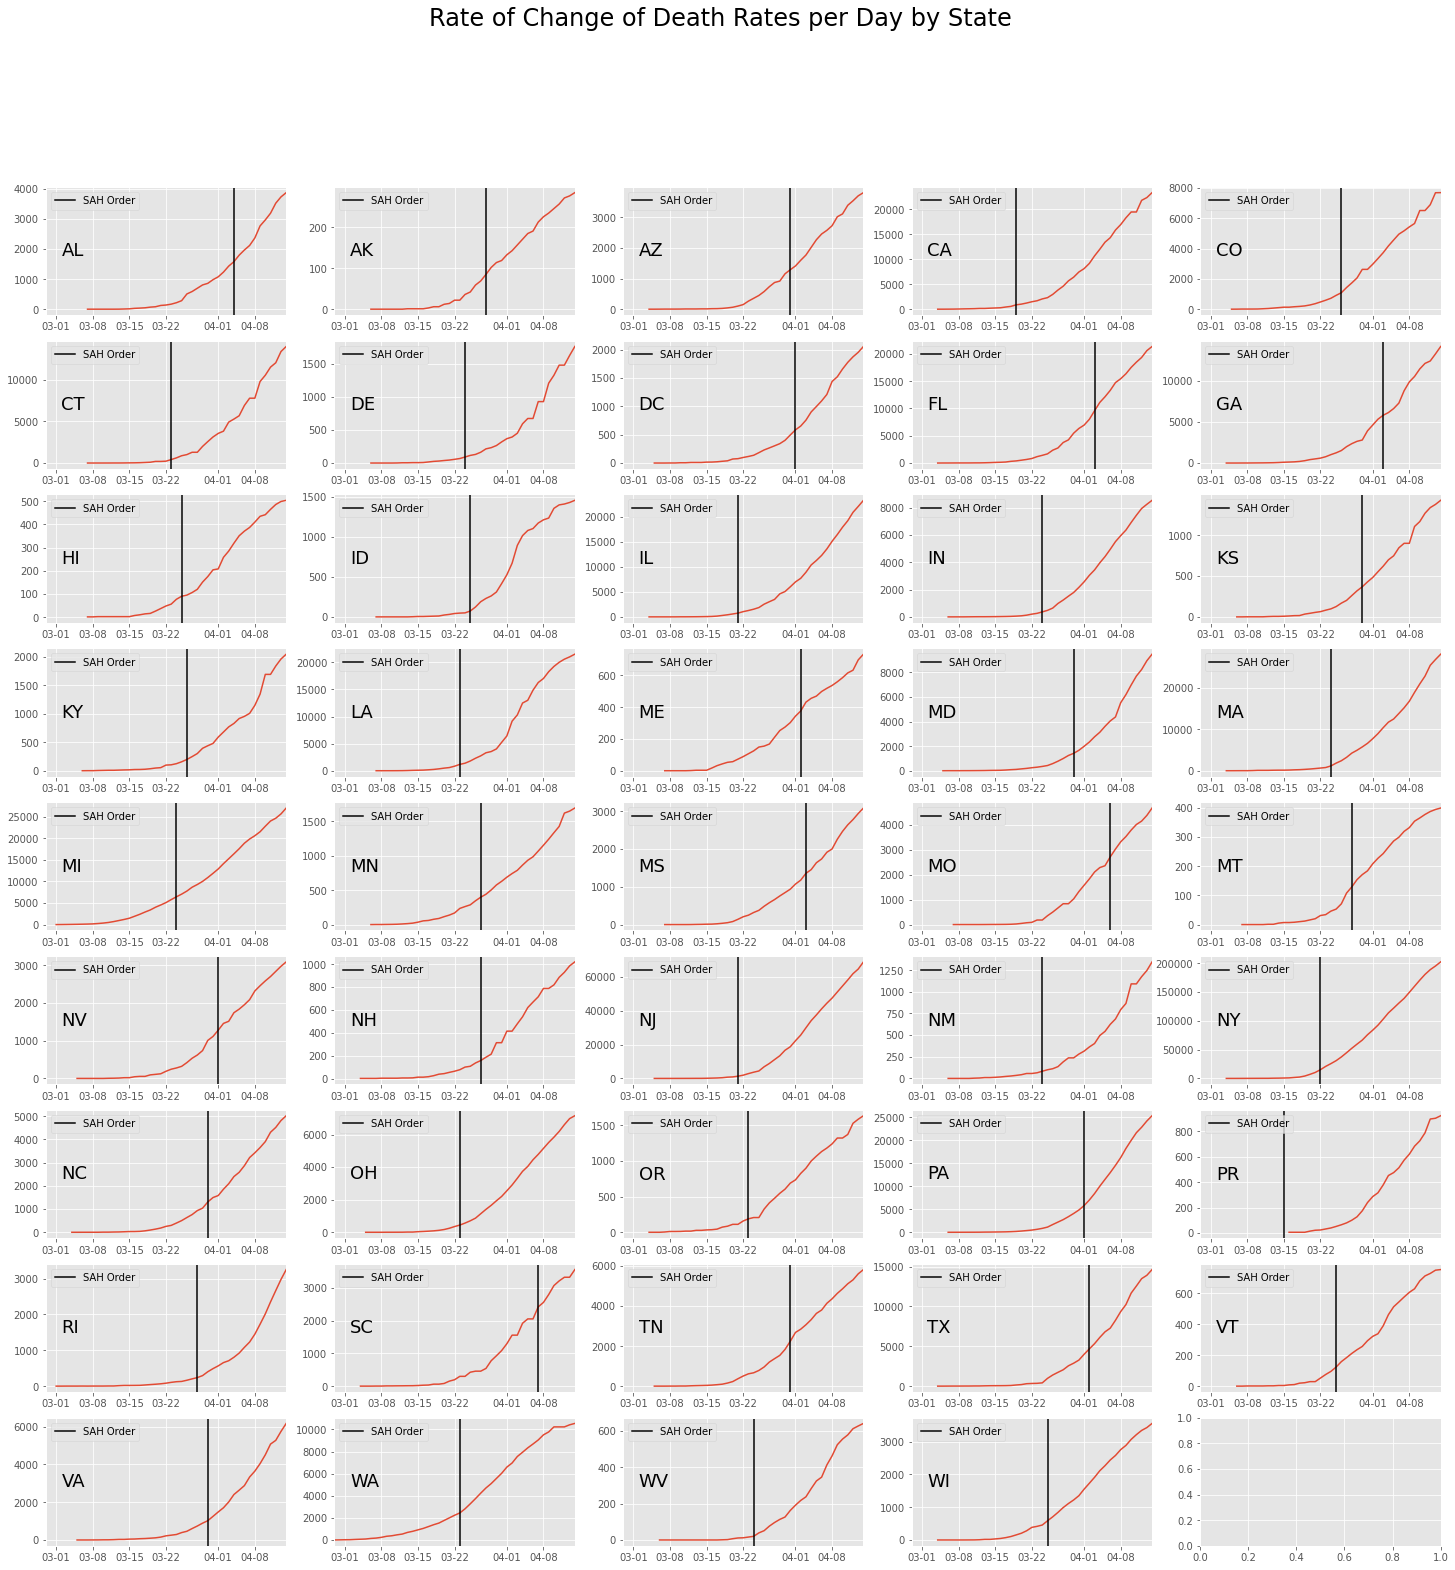

In [38]:
# Plot parameters
index = 0
states_used = []
plt.style.use('ggplot')
fig_rows = math.ceil((len(SAH_data) / 5))
myFmt = mdates.DateFormatter('%m-%d')

# Plots
fig, ax = plt.subplots(fig_rows, 5, figsize = (25, 25))
for i in range(fig_rows):
    for j in range(5):
        name = SAH_data['state'][index] # name of the state
        SAHorder = SAH_data['SAH_Order_Date'][index] # Date of the SAH order in that state
        plot_data = data.loc[data['state'] == name] # Data filtered to that state
        centerrate = max(plot_data['positive']) / 2 # Center of the y-axis for each state
        ax[i, j].plot(plot_data['date'], plot_data['positive']) # Plot deathIncrease over time
        ax[i, j].set_xlim([mindate, maxdate]) # set x axis range
        #ax[i, j].set_ylim([min_roc, max_roc])
        ax[i, j].axvline(SAHorder,  label='SAH Order', color='black') # Plot vertical line for SAH order
        ax[i, j].xaxis.set_major_formatter(myFmt) # Format X-axis
        ax[i, j].text(mindate + datetime.timedelta(days=3), centerrate, name, verticalalignment='center', horizontalalignment='left', fontsize = 18) # Put name of state on the chart
        ax[i, j].legend() # label the black line as the Stay at Home Order
        states_used.append(name) # check to make sure all states were used
        if index == (len(SAH_data)-1): # Loop to stop the plotting if the end of the 
            break
        else:
            index = index + 1
fig.suptitle('Rate of Change of Death Rates per Day by State', fontsize=24)
plt.show();


# Run Neural Network Model for each State

In [31]:
after_SAH_data.loc[after_SAH_data['state'] == 'AL']

,date,state,positive,death,hospitalized,deathIncrease,hospitalizedIncrease,positiveIncrease,SAH_Order_Date,Population,deathIncrease_ROC,deaths_per_M,death_rt_per_M,deathIncrease_ROC_per_M,after_SAH_Order
40,2020-04-14,AL,3876.0,110.0,493.0,11.0,36.0,142.0,2020-04-04,4900000,5.0,22.448980,2.244898,1.020408,1
41,2020-04-13,AL,3734.0,99.0,457.0,6.0,20.0,209.0,2020-04-04,4900000,4.0,20.204082,1.224490,0.816327,1
42,2020-04-12,AL,3525.0,93.0,437.0,2.0,35.0,334.0,2020-04-04,4900000,-9.0,18.979592,0.408163,-1.836735,1
43,2020-04-11,AL,3191.0,91.0,402.0,11.0,34.0,223.0,2020-04-04,4900000,5.0,18.571429,2.244898,1.020408,1
44,2020-04-10,AL,2968.0,80.0,368.0,6.0,35.0,199.0,2020-04-04,4900000,-2.0,16.326531,1.224490,-0.408163,1
45,2020-04-09,AL,2769.0,74.0,333.0,8.0,19.0,400.0,2020-04-04,4900000,-2.0,15.102041,1.632653,-0.408163,1
46,2020-04-08,AL,2369.0,66.0,314.0,10.0,43.0,250.0,2020-04-04,4900000,4.0,13.469388,2.040816,0.816327,1
47,2020-04-07,AL,2119.0,56.0,271.0,6.0,31.0,151.0,2020-04-04,4900000,1.0,11.428571,1.224490,0.204082,1
48,2020-04-06,AL,1968.0,50.0,240.0,5.0,9.0,172.0,2020-04-04,4900000,3.0,10.204082,1.020408,0.612245,1
49,2020-04-05,AL,1796.0,45.0,231.0,2.0,19.0,216.0,2020-04-04,4900000,-6.0,9.183673,0.408163,-1.224490,1


In [32]:
predictions = []

for i in range(len(SAH_data)):
    name = SAH_data['state'][i]
    before = before_SAH_data.loc[before_SAH_data['state'] == name]
    after = after_SAH_data.loc[after_SAH_data['state'] == name]

    # Shrink dataset to the 2 columns I need
    model_data = before[['date', 'death']]
    pred_data = after[['date', 'death']]

    # Prophet requires columns ds (Date) and y (value)
    model_data = model_data.rename(columns={'date': 'ds', 'death': 'y'})
    pred_data = pred_data.rename(columns={'date': 'ds', 'death': 'y'})

    # Make the prophet model and fit on the data
    prophet_model = fbprophet.Prophet(changepoint_prior_scale=0.15)
    prophet_model.fit(model_data)
    predictions.append(prophet_model.predict(pred_data))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run

ValueError: Dataframe has less than 2 non-NaN rows.

In [ ]:
predictions[5]

In [ ]:
for i in range(len(SAH_data)):
    prophet_model.plot(predictions[i])

In [ ]:
# Plot parameters
index = 0
states_used = []
fig_rows = math.ceil((len(SAH_data) / 5))

# Plots
for i in range(len(SAH_data)):
    prophet_model.plot(predictions[index])
    name = SAH_data['state'][index]
    plt.legend(name)
    states_used.append(name)
    if index == (len(SAH_data)-1):
        break
    else:
        index = index + 1